Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensorflow Similarity Supervised Learning Hello World
TensorFlow Similarity is a python library focused on making metric learning with TensorFlow easy. 

It can be used for tasks such as:

- Training and serving models that allow to find similar items, such as images, from large indexes.

- Perform semi-supervised or self-supervised training to
train/boost classification models when you have a large corpus with
few labeled examples.


## Notebook goal

This notebook demonstrate how you can use TensorFlow Similarity to train and query models that allows the fast retrivial of similar looking items on the MNIST dataset. You are going to learn about the main features offered by the `SimilarityModel()` and will:

 1. `train()` a similarity model on a sub-set of the 10 MNIST classes that learn how to project digits in a cosine space

 2. `index()` a few examples of each of the class present in the train dataset (e.g 10 per classes) to make them searchable

 3. `lookup()` some the test data to check that the train model, despite only having a few examples of the classes unseen during training in its index, is still able to retrieve similar looking examples efficiently.

 4. `calibrate()` the model to estimate what is the best distance theshold to separate matching elements from elements belonging to different classes

 5. `evaluate()` how well the model and index perform overall.

 6. `match()` the test dataset to evaluate how well the calibrated model work for classification purpose.

## Things to try 

Along the way you can try the following things to improve the model performance:
- Adding more see classes at training time
- Use a larger embedding by increasing the side of the output
- Add data augmentation pre-processing layers to the model
- Include more examples in the index to give the models more points to choose from.

You can also replace the MNIST digits dataset with the Fashion MNIST dataset one, if you would like to test a more challenging examples while keep the notebook almost identical.


In [2]:
 %load_ext autoreload
 %autoreload 2

In [3]:
import numpy as np
from time import time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [5]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [6]:
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss  # specialized similarity loss
from tensorflow_similarity.layers import MetricEmbedding # layer with l2 regularization
from tensorflow_similarity.models import SimilarityModel # TF model with additional features
from tensorflow_similarity.samplers import MultiShotMemorySampler  # sample data 
from tensorflow_similarity.samplers import select_examples  # select n example per class
from tensorflow_similarity.visualization import viz_neigbors_imgs  # Neigboors vizualisation
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

In [ ]:
tfsim.utils.tf_cap_memory()

In [ ]:
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)

TensorFlow: 2.5.0
TensorFlow Similarity 0.13.4


## Data preparation

We are going to load the MNIST dataset and restrict our training data to only N of the 10 classes (6 by default) to showcase how the model is able to find similar examples from classes unseen during training which is one of the
main reason you would want to use metric learning.


**Important**: Tensorflow similarity expect `y_train` to be the examples class as integers. Accordingly contrary to a standard classification that do categorical encoding we are leavig `y_train` as is.

In [ ]:
NUM_CLASSES = 6  #@param {type: "slider", min: 1, max: 10}
classes = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
# note we added a 11th classes for unknown
labels = ["0", "1",  "2", "3", "4", "5", "6", "7", "8", "9", "Unknown"]
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.constant(x_train / 255.0, dtype='float32')
x_test = tf.constant(x_test / 255.0, dtype='float32')

To learn efficiently each batch must contains at least 2 sample of each class. Additionally it is often useful to have multiple examples of each class so we can mine informative triplet using different mining strategies (e.g *semi-hard* mining).

To make this easy tf_similarity offers `Samplers()` that allows to control the number of classes and minimal ammount of examples in each class. Here we are going `MultiShotMemorySampler()` which allows to sample a dataset that reside in memory and have muliples examples per class.

TensorFlow Similarity provide various loaders to accomodate various requirements including `SingleShotMemorySampler()` for single-shot learning, `TFDatasetMultiShotMemorySampler()` that allows to sample directly a dataset available
in the TensorFlow catalogue and `TFRecordDatasetSampler()` that allows to sample from very large datasets
stored on disk as TFRecords shards.

In [ ]:
CLASS_PER_BATCH = NUM_CLASSES #@param {type:"integer"}
EXAMPLE_PER_CLASS = 6 #@param {type:"integer"}
STEPS_PER_EPOCH = 1000 #@param {type:"integer"}
NUM_CLASSES = 6  #@param {type: "slider", min: 1, max: 10}
classes = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
# note we added a 11th classes for unknown
labels = ["0", "1",  "2", "3", "4", "5", "6", "7", "8", "9", "Unknown"]
sampler = MultiShotMemorySampler(x_train, y_train, 
                                 classes_per_batch=CLASS_PER_BATCH, 
                                 examples_per_class_per_batch=EXAMPLE_PER_CLASS, 
                                 class_list=classes[:NUM_CLASSES],
                                 steps_per_epoch=STEPS_PER_EPOCH)

selecting examples: 100%|██████████| 6/6 [00:00<00:00, 12018.06it/s]


Batch size is 36 (6 class X 6 example per class pre-augmentation



indexing classes: 100%|██████████| 36963/36963 [00:00<00:00, 3891807.88it/s]


## model setup

### Model definition

Triplet loss models are normal `tensorflow.keras` models except their output is a distance embeding. We use `SimilarityModel()` instead of the default `Model()` because this subclass contains additional proprerty that makes indexing and searching embeddings easy once the training is done.

In [ ]:
def get_model():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = layers.experimental.preprocessing.Rescaling(1/255)(inputs)
    x = layers.Conv2D(32, 7, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 7, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    # dont make the embedding to large - its slow down the lookups
    outputs = MetricEmbedding(64)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          100416    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)     

## Loss definition

Overall what makes Metric losses different from tradional losses is that:
- They expect different inptus. Instead of having the prediction and the true values be the same, they expect embeddings as `y_preds` and the id (as int32) of the class as `y_true`. 
- You need to specify which `distance` funciton to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.

In this example we are using the `TripleLoss()` loss as it's hyper-parameter free. If you want to improve the model performance, you can try to use a more efficient loss such as the `CircleLoss()` or the `MultiSimilarityLoss()` but that will requires to tune it and adjust the learning rate.

You also adjust the way triplets are mined for the tripletloss by specifiying other mining strategy (e.g using `negative_mining='hard'`)

In [ ]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance, negative_mining_strategy='semi-hard')

## Compilation

Tensorflow similarity use an extended `compile()` method that allows you to specify distance_metrics (metrics that are computed over the distance between the embedding). 

By default the `compile()` method try to infers what type of distance you are using by looking at the fist loss specified. If you use multiples losses and the distance loss is not the first, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [ ]:
LR = 0.001  #@param {type:"float"}
model = get_model()
model.compile(optimizer=Adam(LR), loss=triplet_loss)

Distance metric automatically set to cosine use the distance arg to override.


## Training

Similarity are trained like normal model. Don't expect the validation loss to decrease too much because we only use half of the class on the train data but all class in the validation.

In [ ]:
EPOCHS = 5 #@param {type:"integer"}
LR = 0.001  #@param {type:"float"}
history = model.fit(sampler, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/5
1000/1000 [==============================] - 10s 6ms/step - loss: 0.6571 - val_loss: 0.7333
Warmup complete
Epoch 2/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2404 - val_loss: 0.7241
Epoch 3/5
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1818 - val_loss: 0.7249
Epoch 4/5
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1515 - val_loss: 0.6859
Epoch 5/5
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1417 - val_loss: 0.6936


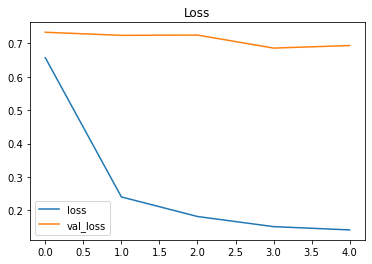

In [ ]:
# expect loss: 0.07 / val_loss: 0.6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

## Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position in a metric space and not a classification, we need a way to find which known example(s) are the closest to determine the class of the incoming data (aka nearest neighboors classication).

To do so we need to **create an index of known example from the 10 cloth classes**. We do this by taking **200 examples from the train dataset which amount to 20 examples** for each class and use the `index()` funtion of the model to build the index.

we store the images (`x_index`) as data in the index (`data=x_index`) so we can display them later. Here the images are small so its not an issue but in general, be careful while storing a lot of data in the index to avoid blewing up your memory. You might consider using a different `Table()` backend if you have to store and serve very large indexes.

Adding more examples per class, will helps increase the accuracy/generalization as having more variations improve the classifier "knowledege" of what variations to expect. 

Reseting the index is not need for the fist run - however always calling it ensure we always start the evaluation with a clean index in case of a re-run

In [ ]:
x_index, y_index = select_examples(x_train, y_train, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 20)
model.reset_index()
model.index(x_index, y_index, data=x_index)

selecting examples: 100%|██████████| 10/10 [00:00<?, ?it/s]


[Indexing 200 points]
|-Computing embeddings
|-Storing data points in index table
|-Adding embeddings to index.
|-Building index.


## Querying

To "classify" our testing data, we need for each testing example to look for its *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

We query a single random example for each class from the test dataset using  `select_examples()` and then find their nearest neighboors using the `single_lookup()` function.

Building NN list: 100%|██████████| 10/10 [00:00<00:00, 3998.00it/s]



Performing NN search



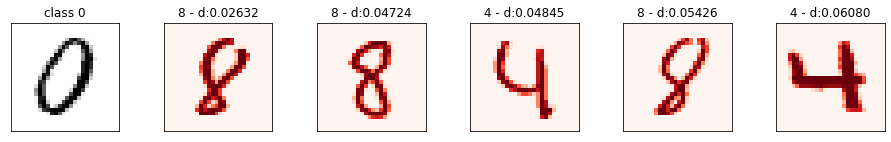

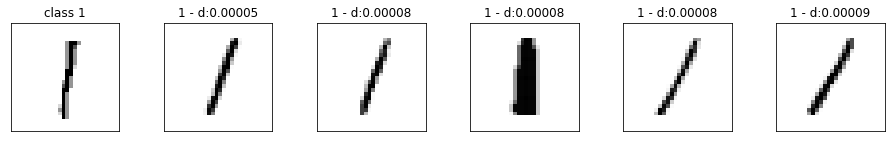

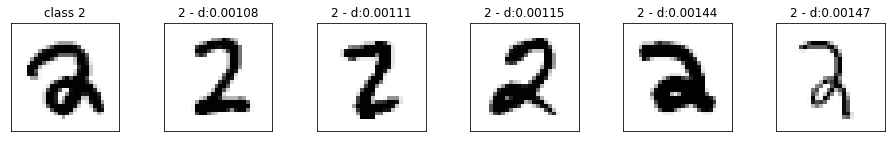

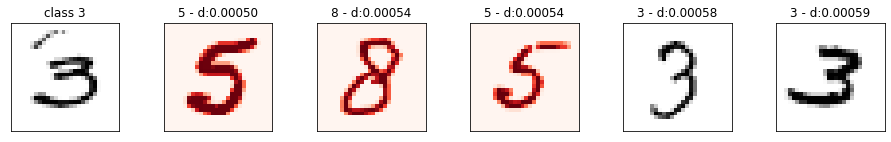

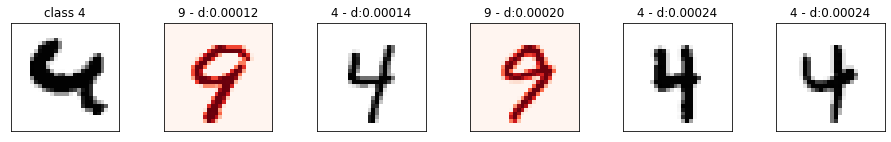

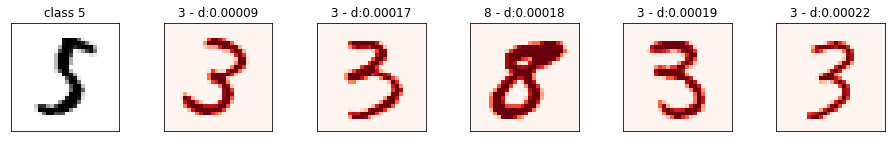

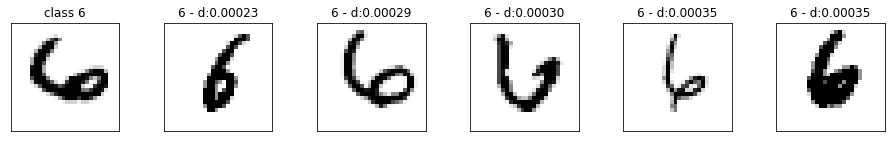

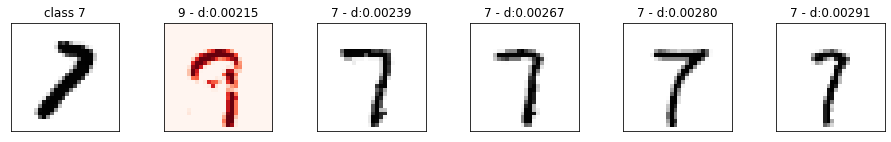

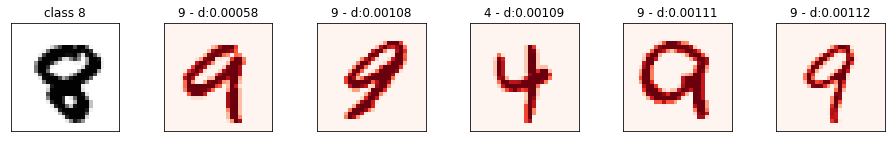

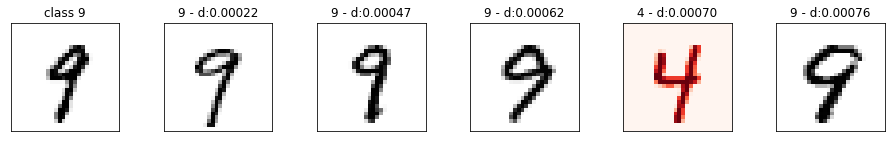

In [ ]:
# re-run to test on other examples
num_neighboors = 5

# select
x_display, y_display = select_examples(x_test, y_test, list(range(10)), 1)

# lookup
nns = model.lookup(x_display, k=num_neighboors)

# display
for idx in np.argsort(y_display):
    viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], 
                      labels=labels, fig_size=(16, 2), cmap='Greys')

## Matching

To be able to tell if an example match a given class, we first need to `calibrate()` the model to know what is the optimal cut point. By default, we only compute an optimal cutpoint that maximizes performance. However you can speficy your own and change the optimization metrics as illustrated in later examples

In [ ]:
num_calibration_samples = 1000
calibration = model.calibrate(x_train[:num_calibration_samples], y_train[:num_calibration_samples], verbose=1)

Building NN list: 100%|██████████| 1000/1000 [00:00<00:00, 42554.55it/s]


Performing NN search




computing thresholds: 100%|██████████| 5000/5000 [00:00<00:00, 1000167.87it/s]


 name       value    distance    accuracy    recall    f1_score
-------  -------  ----------  ----------  --------  ----------
optimal     0.08    0.445162       0.043     0.957    0.082302


Let's look how the performance metrics evolve as the distance between the sample increase. We clearly see the F1 optimial cutpoint where the precision and recall intersect which what the `optimal_cutpoint` represent.

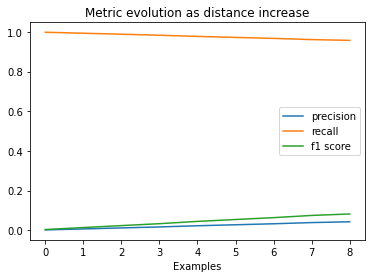

In [ ]:
fig, ax = plt.subplots()
ax.plot(calibration['thresholds']['accuracy'], label='precision')
ax.plot(calibration['thresholds']['recall'], label='recall')
ax.plot(calibration['thresholds']['f1_score'], label='f1 score')
ax.legend()
ax.set_title("Metric evolution as distance increase")
ax.set_xlabel('Examples')
plt.show()

Ploting the precision/recall curve we can see that for a lot of samples from the unseen classes the model is not doing really well (you see the inflexion past 0.6 recall). This can be improved by indexing more data, using data augmentation, a better model or even changing which classes are trained on. 

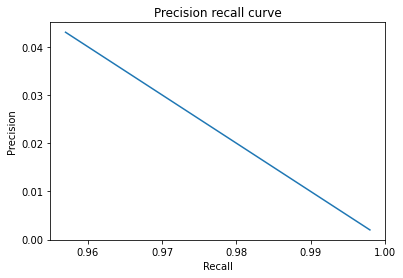

In [ ]:
fig, ax = plt.subplots()
ax.plot(calibration['thresholds']['recall'], calibration['thresholds']['accuracy'])
ax.set_title("Precision recall curve")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

## Evaluation
We evaluate our model ability to accurately match new examples using our calibrated threshold by testing how many examples from the test sets are correctly matched. The example which have a distance above the cutoff are excluded and labeled as unknown.

The evaluation below reports the performance of the model fo 

In [ ]:
metrics = model.evaluate_matching(x_test, y_test)

|-Computing embeddings


Evaluating cutpoints:   0%|          | 0/1 [00:00<?, ?it/s]


Performing NN search



Evaluating cutpoints: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


 [Summary]

name       f1_score    accuracy    recall    distance
-------  ----------  ----------  --------  ----------
optimal   0.0566947      0.0292    0.9708    0.445162


## matching

Let's now match a 100 examples to see how you can use the `match()` function in practice. `match()` return you what class the example belong to based of the content of the index and allows to use your model to make prediction on an unbounded, added after training, classes!

Note: `match()` return -1 by default when the distance between the submited example and any point of the index is above the distance cutpoint.

In [ ]:
num_matches = 10

matches = model.match(x_test[:num_matches], cutpoint='optimal')
rows = []
for idx, match in enumerate(matches):
    rows.append([match, y_test[idx], match == y_test[idx]])
print(tabulate(rows, headers=['Predicted', 'True', 'correct']))

  Predicted    True    correct
-----------  ------  ---------
          7       7          1
          2       2          1
          1       1          1
          0       0          1
          4       4          1
          1       1          1
          9       4          0
          9       9          1
          8       5          0
          9       9          1


## confusion matrix
Let's select a few hundreds samples for each class in the test set to plot the confusion matrix for a few

**note** `tf.math.confusion_matrix` doesn't support negative class so we are going to use **10 as our unknown class**

selecting examples: 100%|██████████| 10/10 [00:00<00:00, 6661.86it/s]


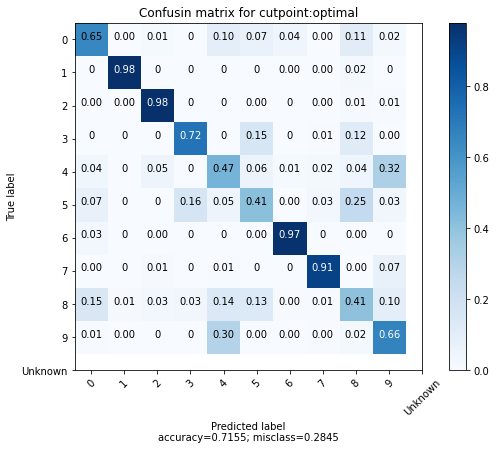

In [ ]:
num_example_per_class = 1000
cutpoint = 'optimal'

x_confusion, y_confusion = select_examples(x_test, y_test, range(10), num_example_per_class)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
confusion_matrix(matches, y_confusion, labels=labels, title='Confusin matrix for cutpoint:%s' % cutpoint)

# Index information

Following `model.summary()` you can get information about the index configuration and its performance using `index_summary()`.

In [ ]:
model.index_summary()

[Info]
------------------  --------
distance            cosine
index table         memory
matching algorithm  nmslib
evaluator           memory
index size          200
calibrated          True
calibration_metric  f1_score
embedding_output
------------------  --------



[Performance]
-----------  ---------------
num lookups  21020
min              1.465e-05
max              1.465e-05
avg              1.465e-05
median           1.465e-05
stddev           3.38813e-21
-----------  ---------------


## Saving and reloading
Saving and reloading the model works as you would expected: 
- `model.save(path)`: save the model and the index on disk (`save_index=False`). By default the index is compressed - can be disabled by setting `compressed=False`
- `model = tf.keras.model.load_model(path)` reload the model. To reload the index you then need to call model.load_index(path)
- `model.save_index(path)` and `model.load_index(path)` allows to save/reload an index indenpendly of saving/loading a model if need to be


### Saving

In [ ]:
# save the model and the index
save_path = 'models/hello_world' #@param {type:"string"}
model.save(save_path)

INFO:tensorflow:Assets written to: models/hello_world\assets


INFO:tensorflow:Assets written to: models/hello_world\assets


### Reloading

In [ ]:
# reload the model
reloaded_model = load_model(save_path)
# reload the index
reloaded_model.load_index(save_path)

Distance metric automatically set to cosine use the distance arg to override.
Loading index data
loaded 200 records from models\hello_world\index
Loading index matcher
Loading calibration data


In [ ]:
#check the index is back
reloaded_model.index_summary()

[Info]
------------------  --------
distance            cosine
index table         memory
matching algorithm  nmslib
evaluator           memory
index size          200
calibrated          True
calibration_metric  f1_score
embedding_output
------------------  --------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


### Query reloaded model
Querying the reloaded model with its reload index works as expected

selecting examples: 100%|██████████| 10/10 [00:00<?, ?it/s]


Performing NN search




Building NN list: 100%|██████████| 10/10 [00:00<00:00, 9981.68it/s]


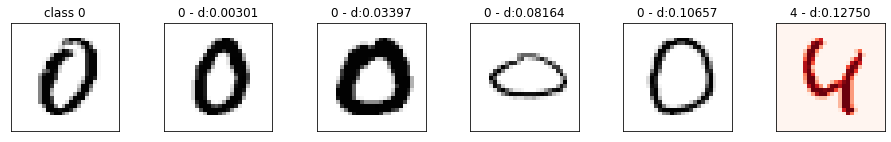

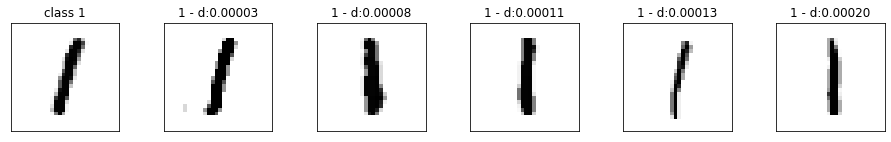

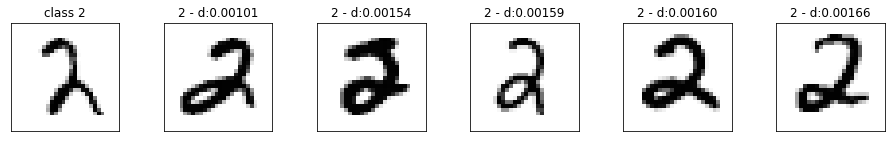

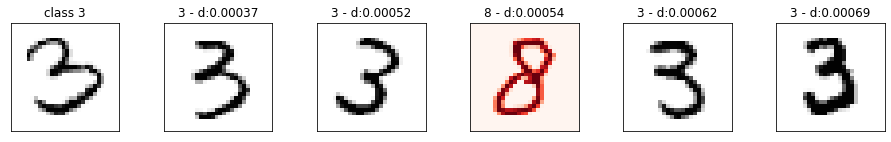

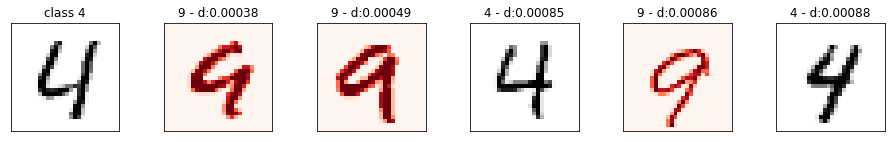

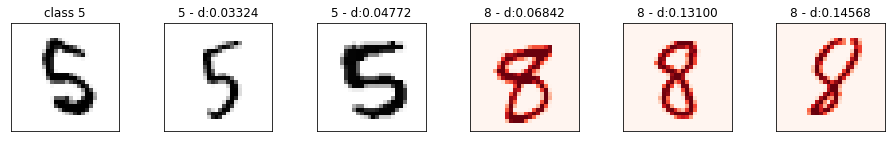

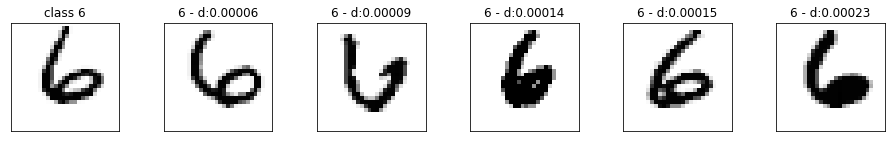

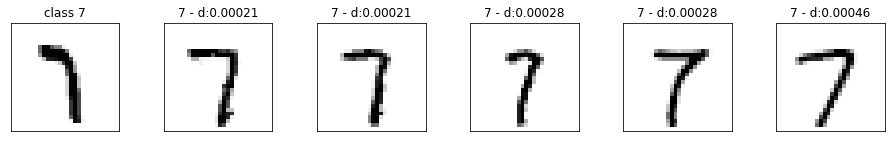

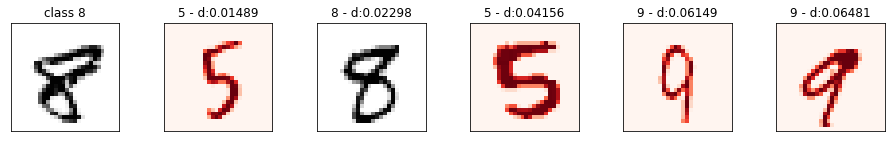

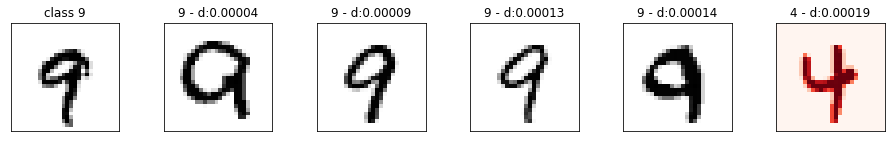

In [ ]:
# re-run to test on other examples
num_neighboors = 5

# select
x_display, y_display = select_examples(x_test, y_test, list(range(10)), 1)

# lookup
nns = model.lookup(x_display, k=num_neighboors)

# display
for idx in np.argsort(y_display):
    viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], 
                      labels=labels, fig_size=(16, 2), cmap='Greys')